## <span style = "color:green">Tutorial/Refresher on Neural Networks and Deep Learning </span>

### <span style = "color:blue">Project Description: </span>
#### Deep Learning has been great and challenging at the same time in decoding how Neural Networks, Convolution networks, RNN and Generative models work. 
#### In Week 5 we were introduced to generative models such as encoders/decoders, GANs which probably were the most challenging. In this project instead of solving a real world problem, I will take a step back and build a tutorial which would also work as a refresher for myself on Neural Nets.

#### <span style = "color:blue">Dataset: </span>
##### For this project I will use the MNIST dataset to experiment with different models that run quickly and I can focus more on the technical aspects of Deep Learning that I can then use to solve real world problems and participate in Kaggle competitions.

**Import Standard Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
import sklearn
import random  

from sklearn.model_selection import train_test_split

**Keras Libraries**

In [2]:
import keras
from keras import layers

### Neural netowrks
from keras.layers import Dense # Dense layers are "fully connected" layers
from keras.models import Sequential # Documentation: https://keras.io/models/sequential/

##CNN
from keras.layers import Conv2D,MaxPooling2D, Input, Flatten, LeakyReLU, Dropout, Reshape

##GAN
from tensorflow.keras.optimizers import Adam
from keras.layers import Reshape, Conv2DTranspose


**Lets import the dataset**

In [11]:
from keras.datasets import mnist
(x_train,y_train), (x_test, y_test) = mnist.load_data()


#### <span style = "color:blue">EDA on the dataset </span>


In [15]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


##### Lets print the first 8 images from the dataset with their labels

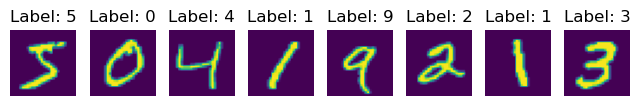

In [125]:
plt.figure(figsize=(8, 8))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

#### Lets get the mean pixel value and see how it is different between the different digits

In [120]:
x_train_mean = np.mean(x_train,axis=(1,2))

mnist_df = pd.DataFrame(zip(y_train,x_train_mean))
mnist_df.columns =['digit', 'mean_pixel']

mnist_df.head()

,digit,mean_pixel
0,5,35.108418
1,0,39.661990
2,4,24.799745
3,1,21.855867
4,9,29.609694


<Axes: xlabel='digit'>

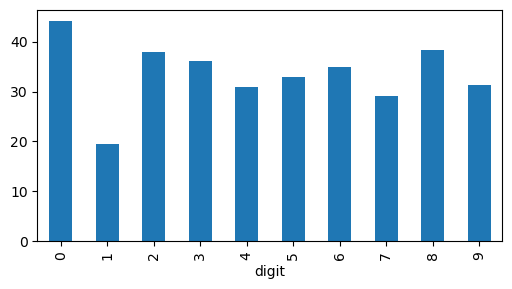

In [96]:
plt.figure(figsize=(6, 3))

mean_values = mnist_df.groupby('digit')['mean_pixel'].mean()
mean_values.plot(kind='bar')


#### 0 has the highest pixel value and 1 has the lowest. The challenge is that some are pretty close for example 2 and 8

In [98]:
round(mean_values,2)

digit
0    44.22
1    19.38
2    37.99
3    36.09
4    30.95
5    32.83
6    35.01
7    29.20
8    38.29
9    31.26
Name: mean_pixel, dtype: float64

#### lets look at a box plot

<Axes: title={'center': 'mean_pixel'}, xlabel='digit'>

<Figure size 200x200 with 0 Axes>

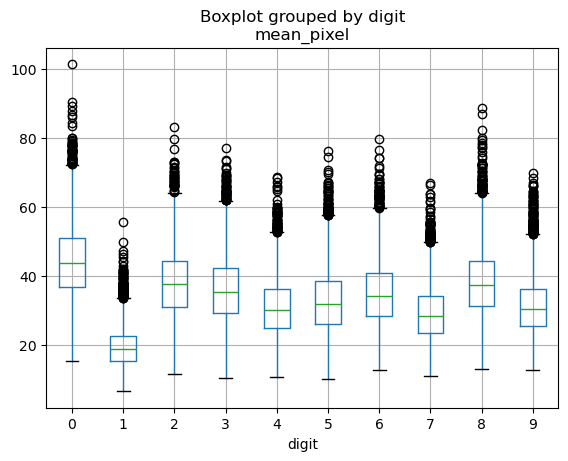

In [115]:
plt.figure(figsize=(2, 2))

mnist_df.boxplot(column='mean_pixel', by='digit')


#### Lots of outliers with much higher mean value ...lets look at one of the outliers....The below image shows why

       digit  mean_pixel
41358      0  101.381378


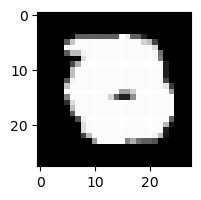

In [131]:
print(mnist_df[mnist_df['mean_pixel']>100])
plt.figure(figsize=(2, 2))

plt.imshow(x_train[41358],cmap='gray')

#### lets look at 1 more plot

       digit  mean_pixel
5972       8   86.806122
10203      0   86.682398
10237      0   83.436224
10245      0   84.227041
10259      0   87.732143
10283      0   86.168367
11746      0   80.026786
25285      0   90.477041
25321      8   88.711735
31030      8   82.360969
41358      0  101.381378
59365      2   83.125000
59395      8   80.053571
59439      0   89.255102


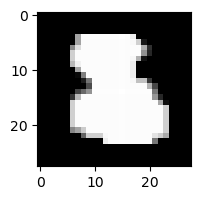

In [133]:
print(mnist_df[mnist_df['mean_pixel']>80])
plt.figure(figsize=(2, 2))

plt.imshow(x_train[5972],cmap='gray')

#### Heatmap for 1 digit to see how pixels impact

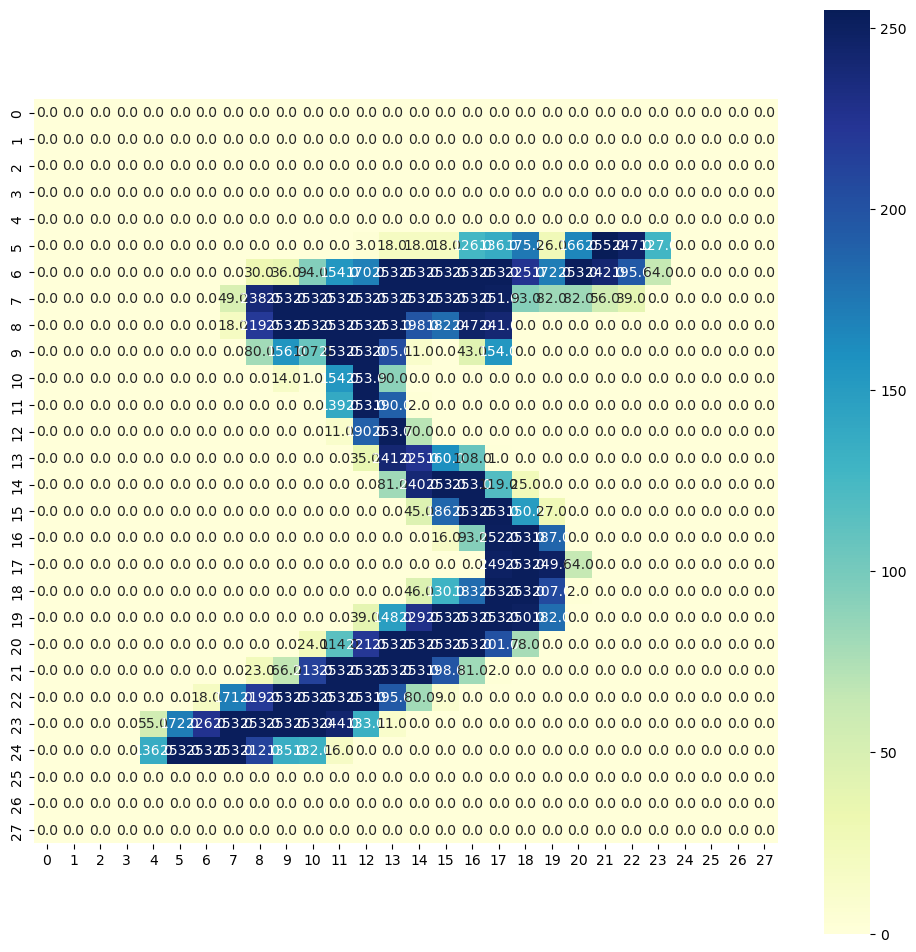

In [143]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(x_train[0], annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

#### Lets now scale the dataset before we run a neural network

In [219]:
x_train_scaled = x_train.astype('float32') / 255
x_test_scaled = x_test.astype('float32') / 255
x_train_scaled = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_scaled = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(60000, 784)
(10000, 784)


## <span style = "color:green">Model 1: Simple Neural Network </span>

#### Convert labels to one hot vectors

In [220]:
num_classes = 10
y_train_scaled = keras.utils.to_categorical(y_train, num_classes)
y_test_scaled = keras.utils.to_categorical(y_test, num_classes)
print(y_train_scaled[0:2])
print(y_test_scaled[0:2])


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


#### Architecture: we will keep the architecture very simple here:
1. Dense Layer with 64 neurons/RELU
2. Dense Layer with 32 neurons/RELU
3. Dense layer with 16 neurons/RELU
4. Output layer with 10 classes and softmax activation

#### HyperPartameters: 
1. optimizer = adam/sgd {we can try both}
2. metrics = accuracy
3. Loss = categorical cross entropy (since we have more than 2 classes)

In [221]:
model = Sequential()
model.add(keras.Input(shape=(784,)))
model.add(Dense(units=64,activation='relu'))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(units=16,activation='relu'))
model.add(Dense(units=10,activation='softmax'))
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,018 (207.10 KB)

 Trainable params: 53,018 (207.10 KB)

 Non-trainable params: 0 (0.00 B)

In [222]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [223]:
history1 = model.fit(x_train_scaled, y_train_scaled, batch_size=128, epochs=5, validation_data=(x_test_scaled, y_test_scaled))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4279 - loss: 5.4512 - val_accuracy: 0.6346 - val_loss: 1.1012
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6725 - loss: 1.0070 - val_accuracy: 0.7508 - val_loss: 0.8375
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7880 - loss: 0.7213 - val_accuracy: 0.8542 - val_loss: 0.5829
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8828 - loss: 0.4879 - val_accuracy: 0.8925 - val_loss: 0.4432
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9155 - loss: 0.3556 - val_accuracy: 0.9223 - val_loss: 0.3397


#### Plot Loss and Accuracy

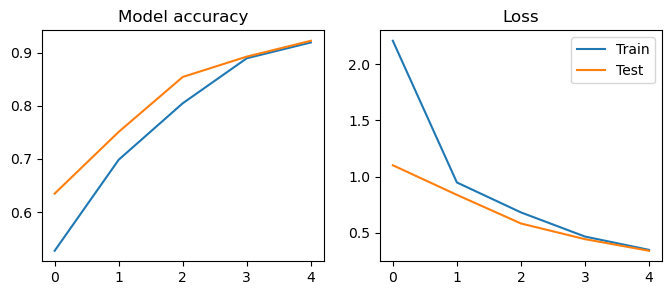

In [224]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

ax1.plot(history1.history['accuracy'])
ax1.plot(history1.history['val_accuracy'])
ax1.set_title('Model accuracy')

ax2.plot(history1.history['loss'])
ax2.plot(history1.history['val_loss'])
ax2.set_title('Loss')

plt.legend(['Train', 'Test'], loc='best')

#### Predict and check confusion matrix

In [229]:
#yhat = model.predict(x_test_scaled)
#yhat = np.argmax(yhat, axis=1) ### convert back to labels
print(yhat[0:10])
print(y_test[0:10])

[3 1 3 0 7 2 7 1 2 1]
[3 1 3 4 7 2 7 1 2 1]


In [227]:
print(sklearn.metrics.confusion_matrix(y_test, yhat))

[[ 957    0    1    1    1    4   13    2    0    1]
 [   0 1090    4    1    0    1   33    0    6    0]
 [   7    0  954   22    1    0   15    2   31    0]
 [   1    0   19  909    0   36    7   15   23    0]
 [   4    0    1    0  913    1   21    1   22   19]
 [   9    0    1   15    2  826   25    3    9    2]
 [  20    2    4    0    3   22  902    0    5    0]
 [   4    0   19   19    0    0   15  951    5   15]
 [   4    0   16   31   26   36   24    7  827    3]
 [   9    3    1    5   31    9   15   24   18  894]]


#### Pretty good....lets look at some images that go misclassified

In [231]:
diff=[]
for i in range(len(yhat)):
    if yhat[i] != y_test[i]:
        diff.append([i,yhat[i],y_test[i]])
print(diff[0])


[33, 0, 4]


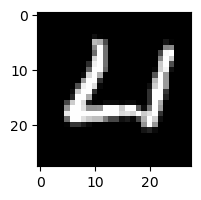

In [232]:
plt.figure(figsize=(2, 2))
plt.imshow(x_test[33],cmap='grey')

#### This would have been difficult...lets look at another

In [233]:
diff[1]

[63, 2, 3]

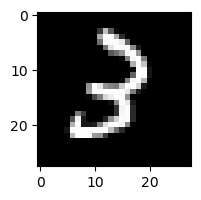

In [234]:
plt.figure(figsize=(2, 2))
plt.imshow(x_test[63],cmap='grey')

#### This should have been classified...lets now try the convoluted network

## <span style = "color:green">Model 2: CNN </span>

### Architecture:
We will use 2 Convoluted and 2 Max Pooling Layers with 1 Dense Layer
1. Conv layer with 32 filters
2. Max Pooling
3. Conv Layer with 64 filters
4. Max Pooling
5. Dense Layer with 128 neurons
6. Output Layer with 10 classes

Lets see how this performs

#### lets scale the data

In [255]:
x_train_scaled_cnn = x_train.astype('float32') / 255
x_test_scaled_cnn = x_test.astype('float32') / 255
x_train_scaled_cnn = np.expand_dims(x_train_scaled_cnn, -1) ### this is to add the 3rd dimension to the data for RGB
x_test_scaled_cnn = np.expand_dims(x_test_scaled_cnn, -1) ### this is to add the 3rd dimension to the data for RGB

print(x_train_scaled_cnn.shape)


(60000, 28, 28, 1)


#### Build the Convoluted Net based on the above architecture)

In [259]:

model = Sequential()
model.add(Input(shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dense(10, activation="softmax"))

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Optimizer: Adam, Loss is categorical_cross entropy. Epochs = 5....We will use the same partameters as a simple neural network.

In [260]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [263]:
model.fit(x_train_scaled_cnn, y_train_scaled, batch_size=128, epochs=5, validation_data=(x_test_scaled_cnn, y_test_scaled))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9866 - loss: 0.0427 - val_accuracy: 0.9883 - val_loss: 0.0352
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9894 - loss: 0.0338 - val_accuracy: 0.9877 - val_loss: 0.0354
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9930 - loss: 0.0248 - val_accuracy: 0.9887 - val_loss: 0.0345
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9940 - loss: 0.0179 - val_accuracy: 0.9898 - val_loss: 0.0321
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.9957 - loss: 0.0128 - val_accuracy: 0.9898 - val_loss: 0.0338


#### Much higher accuracy numbers with Conv Net...Lets check the accuracy & loss trends by epoch and the confusion matrix.

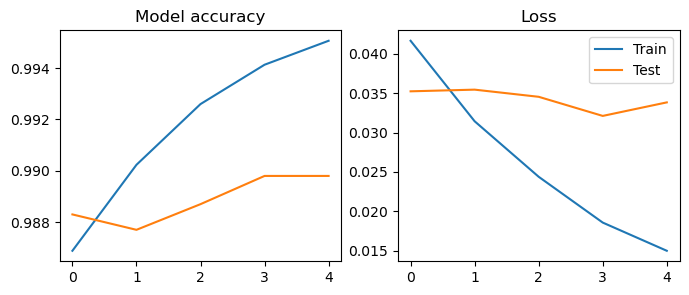

In [264]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

ax1.plot(model.history.history['accuracy'])
ax1.plot(model.history.history['val_accuracy'])
ax1.set_title('Model accuracy')

ax2.plot(model.history.history['loss'])
ax2.plot(model.history.history['val_loss'])
ax2.set_title('Loss')

plt.legend(['Train', 'Test'], loc='best')

In [265]:
yhat = model.predict(x_test_scaled_cnn)
yhat = np.argmax(yhat, axis=1) ### convert back to labels
print(yhat[0:10])
print(y_test[0:10])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


In [266]:
print(sklearn.metrics.confusion_matrix(y_test, yhat))

[[ 976    0    2    0    0    0    0    0    1    1]
 [   0 1129    1    3    0    0    0    0    2    0]
 [   0    0 1022    5    1    0    0    3    1    0]
 [   0    0    0 1006    0    1    0    0    3    0]
 [   0    0    0    0  978    0    0    0    1    3]
 [   1    0    0   12    0  877    1    0    1    0]
 [   4    2    1    0    3    8  937    0    3    0]
 [   0    1    3    5    0    0    0 1013    4    2]
 [   2    0    1    0    0    0    0    1  969    1]
 [   0    2    0    5    4    4    0    2    1  991]]


#### Lets look at some misclassifications

In [267]:
diff=[]
for i in range(len(yhat)):
    if yhat[i] != y_test[i]:
        diff.append([i,yhat[i],y_test[i]])
print(diff[0])


[18, 8, 3]


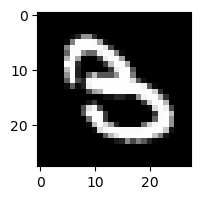

In [268]:
plt.figure(figsize=(2, 2))
plt.imshow(x_test[18],cmap='grey')

[62, 5, 9]


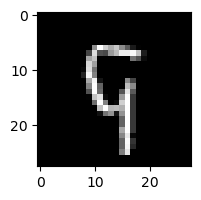

In [270]:
print(diff[1])
plt.figure(figsize=(2, 2))
plt.imshow(x_test[62],cmap='grey')

#### Looking at the first 2 images, it is fair that the network was not able to classify. However, it is entirely possible to build a stronger network that can give 100% accuracy with this dataset. 

## <span style = "color:green">Model 3: GAN </span>

#### Lets first build the discriminator model
**Architecture**
1. Input Layer: image generated by the generator
2. 2 Convolutional Layers with 64 3*3 filters and Leaky Relu as activation
3. Output layer of 1 (classify image as real or fake)

In [3]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [13]:
# define model
model = define_discriminator()
# summarize the model
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         3,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,705 (159.00 KB)

 Trainable params: 40,705 (159.00 KB)

 Non-trainable params: 0 (0.00 B)

Lets train the discriminator with real mnist images of a class label of one and randomly generated fake images with label 0

In [14]:
x = np.expand_dims(x_train, axis=-1)
x = x.astype('float32') / 255
x.shape

(60000, 28, 28, 1)

#### Create random samples of real images

In [15]:
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn


In [16]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, 1))
	return X, y

In [17]:
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [21]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

Lets train the discriminator

In [22]:
train_discriminator(model, x)

>1 real=40% fake=50%
>2 real=49% fake=55%
>3 real=56% fake=61%
>4 real=60% fake=64%
>5 real=63% fake=66%
>6 real=65% fake=68%
>7 real=67% fake=69%
>8 real=69% fake=71%
>9 real=69% fake=71%
>10 real=71% fake=72%
>11 real=71% fake=73%
>12 real=73% fake=74%
>13 real=73% fake=74%
>14 real=74% fake=75%
>15 real=75% fake=76%
>16 real=76% fake=76%
>17 real=76% fake=77%
>18 real=77% fake=78%
>19 real=78% fake=78%
>20 real=78% fake=79%
>21 real=79% fake=80%
>22 real=80% fake=80%
>23 real=80% fake=81%
>24 real=81% fake=81%
>25 real=82% fake=82%
>26 real=82% fake=82%
>27 real=83% fake=83%
>28 real=83% fake=84%
>29 real=84% fake=84%
>30 real=84% fake=85%
>31 real=85% fake=85%
>32 real=85% fake=86%
>33 real=86% fake=86%
>34 real=86% fake=86%
>35 real=87% fake=87%
>36 real=87% fake=87%
>37 real=87% fake=87%
>38 real=88% fake=88%
>39 real=88% fake=88%
>40 real=88% fake=88%
>41 real=89% fake=89%
>42 real=89% fake=89%
>43 real=89% fake=89%
>44 real=89% fake=89%
>45 real=90% fake=90%
>46 real=90% fake=9

#### Build the generator model

Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.The latent space has no meaning but by taking points from this space, the model will be able to convert it into images.
Outputs: Image of 28×28 pixels with pixel values in [0,1]

In [25]:
def define_generator(latent_dim):
    model = Sequential()
	# foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Input(shape = (latent_dim,)))
    model.add(Dense(n_nodes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

In [26]:
latent_dim=100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 1)      │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,164,289 (4.44 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

The output layer will produce 28*28*1 image from an input of 100 random numbers

#### Use the generator to generate fake samples

In [27]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [28]:
def generate_fake_samples(generator_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

#### Lets generate some fake images

In [29]:
latent_dim=100
n_samples = 25
X, y = generate_fake_samples(model, latent_dim, n_samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


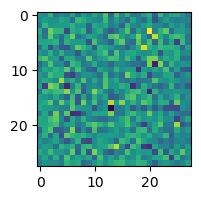

In [30]:
plt.figure(figsize=(2, 2))
plt.imshow(X[0])

#### Now lets train the generator

The weights in the generator model are updated based on the performance of the discriminator model.
When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.
This defines the zero-sum or adversarial relationship between these two models.

In [31]:
def define_gan(generator_model, discriminator_model):
	# make weights in the discriminator not trainable
	discriminator_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator_model)
	# add the discriminator
	model.add(discriminator_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

#### Lets create the GAN Model

In [32]:
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 28, 28, 1)      │     1,164,289 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 1)              │        40,705 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,204,994 (4.60 MB)

 Trainable params: 1,164,289 (4.44 MB)

 Non-trainable params: 40,705 (159.00 KB)

In [33]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

#### Now lets define the entire GAN Model

In [35]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print((i+1, j+1, bat_per_epo, d_loss, g_loss))

#### Evaluate performance of the model

In [56]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
    
    #plt.show()
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()


In [44]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.keras' % (epoch + 1)
	g_model.save(filename)


#### Lets add plots and evaluation to our train function

In [45]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print((i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		#if (i+1) % 5 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim)
        

#### Lets train the GAN Model

In [ ]:
train(g_model, d_model, gan_model, x, latent_dim,n_epochs=2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step
(1, 1, 234, array(0.8794048, dtype=float32), [array(0.8794048, dtype=float32), array(0.8794048, dtype=float32), array(0.228439, dtype=float32)])
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
(1, 2, 234, array(0.8794146, dtype=float32), [array(0.8794146, dtype=float32), array(0.8794146, dtype=float32), array(0.22841933, dtype=float32)])
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
(1, 3, 234, array(0.8793752, dtype=float32), [array(0.8793752, dtype=float32), array(0.8793752, dtype=float32), array(0.22848111, dtype=float32)])
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step
(1, 4, 234, array(0.87937886, dtype=float32), [array(0.87937886, dtype=float32), array(0.87937886, dtype=float32), array(0.22822076, dtype=float32)])
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
(1, 5, 234, array(0.8793693, dtype=float32), [array(0.8793693, dtype=float32), array(0.8793693, dtype=float32), array(0.22820391, dtype=float32)])
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 361ms/step
(1, 6, 234, array(0.87938714, 

#### generate images after 3 epoch

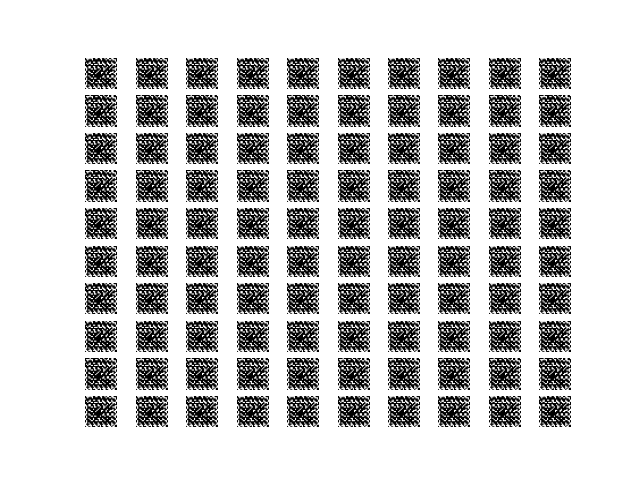

## <span style = "color:green">Project Summary </span>

#### In this project (or refresher) we used the MNIST dataset to implement a simple neural network aercitecture using Keras Library. The accuracy was 90% and we could see examples where the nework should have recognozed a digit but could not. A convoluted network on the other hand performed much better than a simple network and produced accuracy of almost 99%. CNNs are the way to go when it comes to vision based models.

#### The last model we experimented with was GAN. I could only run it for 3 epochs and the images just had some basic line structure forming but if we run the model for 100+ epochs it would start producing images very close to the real images.

## <span style = "color:green">Next Steps </span>

#### Before experimenting more with more complex deep learning algorithms need to get more computing power and probably a GPU based system just to run these models.
